In [191]:
import pickle
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from pprint import pprint
import seaborn as sns

In [255]:
run = 'tenth'


# Read Sumo distance logs

In [343]:
data_dist = []
data_speed = []
with open(f'../logs/{run}/sumo_positions.dat') as fr:
    lines = fr.readlines()
    for row in csv.reader(lines, delimiter=';'):
        # if row[0] == 'POS':
        #     data.append({"ts": float(row[1]), "sumo_id": row[2], 'x': float(row[3]), 'y': float(row[4])})
        if row[0] == 'DST':
            data_dist.append({"ts": float(row[1]), "sumo_id": row[2], 'dist': float(row[3])})
        if row[0] == 'SPD':
            data_speed.append({"ts": float(row[1]), "sumo_id": row[2], 'speed': float(row[3]), 'acc': float(row[4])})
sumo_dist_df = pd.DataFrame(data_dist)
sumo_speed_df = pd.DataFrame(data_speed)
sumo_df = pd.merge(sumo_dist_df, sumo_speed_df)
#t=sumo_pos_df.pivot_table(values=["x", "y"], index="ts",columns="sumo_id")
sumo_df = sumo_df.set_index('ts')


In [442]:
t0 = sumo_df.index.values[0]+190
duration = 100


# Distance between cars

Text(0.5, 28.999999999999986, '')

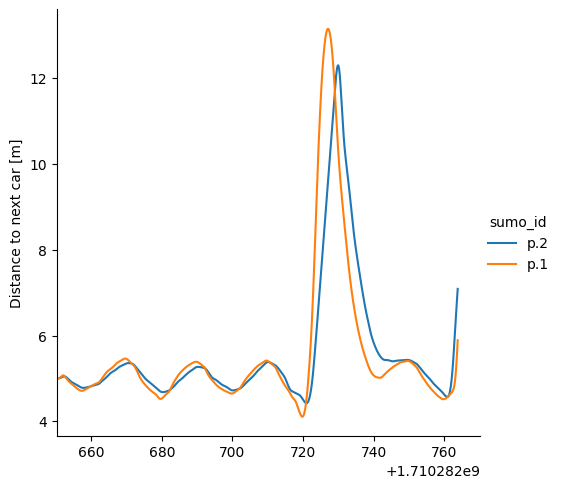

In [346]:
sns.relplot(sumo_df[sumo_df.sumo_id!='p.0'], x='ts', y='dist', hue='sumo_id', kind='line')
ax = plt.gca()
# get current xtick labels
xticks = ax.get_xticks()
ax.set_xlim(t0, t0+duration)
# convert all xtick labels to selected format from ms timestamp
#ax.set_xticklabels([pd.to_datetime(tm, unit='s').strftime('%H:%M:%S') for tm in xticks],rotation=50)
ax.set_ylabel("Distance to next car [m]")
ax.set_xlabel("")
#ax.set_ylim(4,6)


Text(0.5, 28.999999999999986, '')

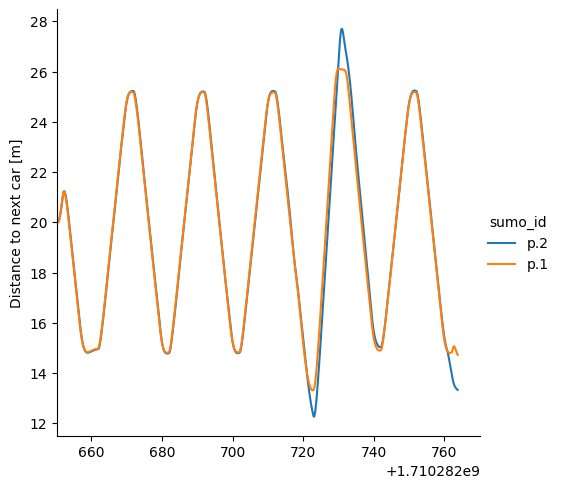

In [320]:
sns.relplot(sumo_df[sumo_df.sumo_id!='p.0'], x='ts', y='speed', hue='sumo_id', kind='line')
ax = plt.gca()
# get current xtick labels
xticks = ax.get_xticks()
ax.set_xlim(t0, t0+duration)
# convert all xtick labels to selected format from ms timestamp
#ax.set_xticklabels([pd.to_datetime(tm, unit='s').strftime('%H:%M:%S') for tm in xticks],rotation=50)
ax.set_ylabel("Distance to next car [m]")
ax.set_xlabel("")
#ax.set_ylim(12,27)

# Read Sumo network logs


In [321]:
def process_row(row):
    if row[0] == 'RX_MSG':
        msg = json.loads(row[3])['content']
        d = {
            'sumo_id': row[2],
            'time': float(row[1]),
            'sender': msg['sender'],
            'recipient': msg['recipient'],
            'sent_at': msg['ts'],
            'delay': (float(row[1])- msg['ts'])*1000,
            'link': f"{msg['sender'][2:]} {msg['recipient'][2:]}"}
        return d

data = []
with open(f'../logs/{run}/p.1.log') as fr:
    lines = fr.readlines()
    for row in csv.reader(lines, delimiter=';'):
        d = process_row(row)
        if d:
            data.append(d)
with open(f'../logs/{run}/p.2.log') as fr:
    lines = fr.readlines()
    for row in csv.reader(lines, delimiter=';'):
        d = process_row(row)
        if d:
            data.append(d)
        

sumo_net_df = pd.DataFrame(data)
sumo_net_df=sumo_net_df.set_index('time')

#sumo_net_df['time'] = pd.to_datetime(sumo_net_df['time'], unit='s')

(1710282650.2390344, 1710282770.2390344)

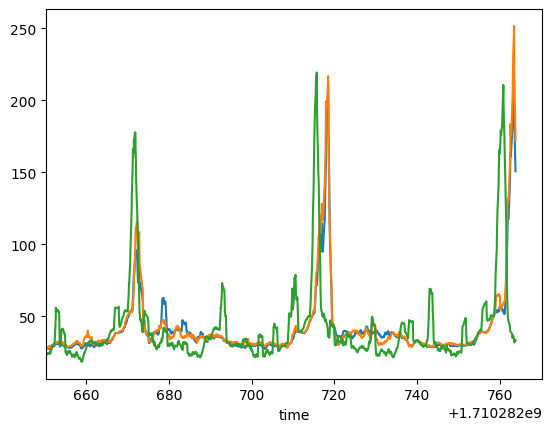

In [334]:
sumo_net_df[sumo_net_df.link == '0 1'].delay.rolling(10).mean().plot()
sumo_net_df[sumo_net_df.link == '0 2'].delay.rolling(10).mean().plot()
sumo_net_df[sumo_net_df.link == '1 2'].delay.rolling(10).mean().plot()

plt.xlim(t0, t0+duration)


Text(0.5, 28.999999999999986, '')

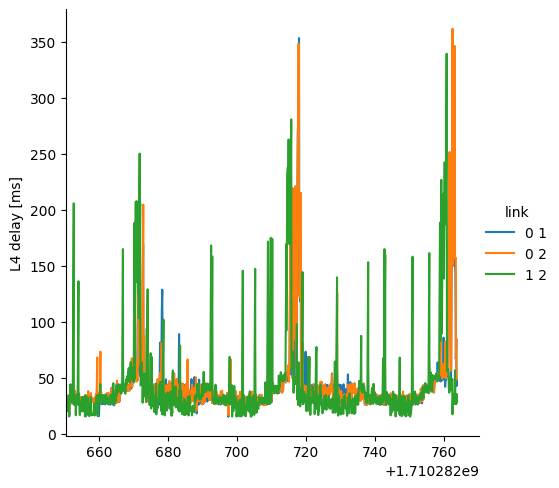

In [323]:
sns.relplot(sumo_net_df, x='time', y='delay', hue='link', kind='line')
ax = plt.gca()
# get current xtick labels
xticks = ax.get_xticks()
ax.set_xlim(t0, t0+duration)
# convert all xtick labels to selected format from ms timestamp
#ax.set_xticklabels([pd.to_datetime(tm, unit='s').strftime('%H:%M:%S') for tm in xticks], rotation=50)
ax.set_ylabel("L4 delay [ms]")
ax.set_xlabel("")

# Read OAI logs

In [352]:
def parse_mac(dump):
    for ue_raw in dump.split("UE RNTI")[1:]:
        rnti = ue_raw[1:5] 
        ue_raw_lines = ue_raw.split('\n')
        try:
            rsrp = int(ue_raw_lines[0].split('RSRP')[1][1:4])
        except:
            rsrp = np.nan
        dl_bler = float(ue_raw_lines[1].split('BLER')[1][1:8])
        ul_bler = float(ue_raw_lines[2].split('BLER')[1][1:8])
        dl_mcs = int(ue_raw_lines[1].split('MCS')[1][5:])
        ul_mcs = int(ue_raw_lines[2].split('MCS')[1][5:])
        tx_bytes = int(ue_raw_lines[3][19:34])
        rx_bytes = int(ue_raw_lines[3][38:53])
        yield {'rnti': rnti, 'tx_bytes': tx_bytes, 'rx_bytes': rx_bytes, 'dl_bler': dl_bler, 'ul_bler':ul_bler, 'dl_mcs':dl_mcs, 'ul_mcs': ul_mcs, 'rsrp': rsrp}
    

with open(f'../logs/{run}/oai_logs.pickle', 'rb') as fb:
    oai_logs = pickle.load(fb)


data = []
for l in oai_logs[10:]:
    if(l['file'] == './nrMAC_stats.log'):  
        metrics = parse_mac(l['content'])
        for m in metrics:
            data.append({
                'time': l['time'],
            } | m)
oai_df = pd.DataFrame(data)

oai_df_idx = oai_df.set_index('time')



# BLER, MCS

(1710282650.2390344, 1710282770.2390344)

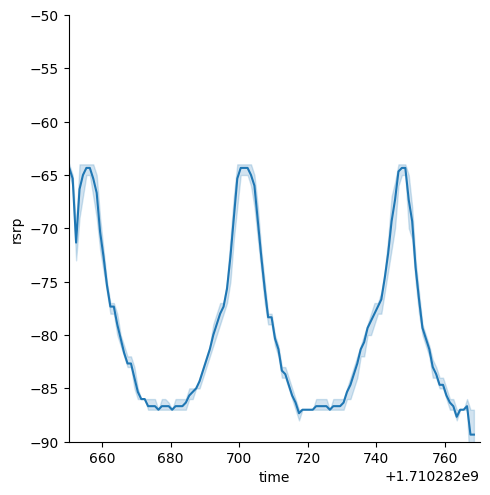

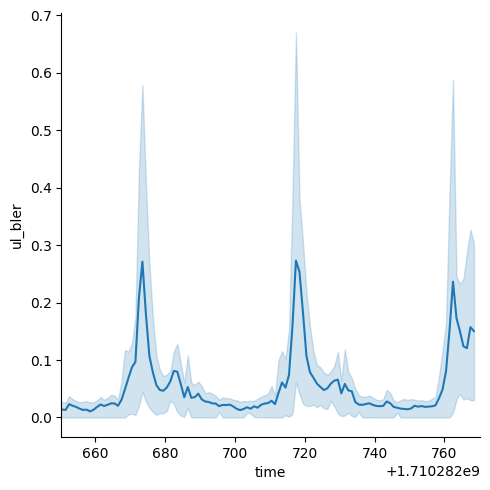

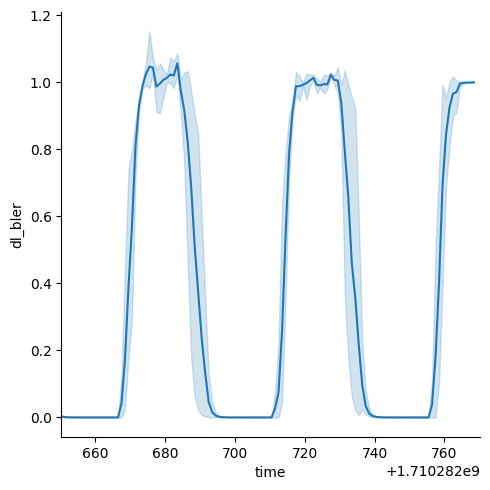

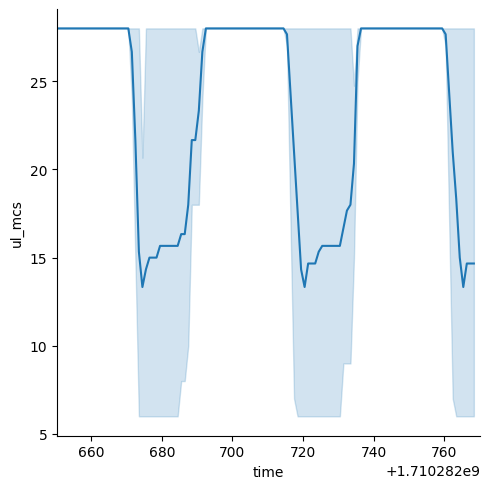

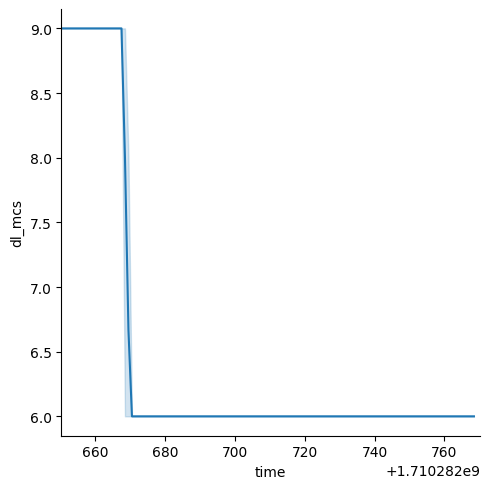

In [353]:
sns.relplot(oai_df, x='time', y='rsrp', kind='line')
ax = plt.gca()
# get current xtick labels
xticks = ax.get_xticks()
ax.set_xlim(t0, t0+duration)
ax.set_ylim(-90, -50)


sns.relplot(oai_df, x='time', y='ul_bler',kind='line')
ax = plt.gca()
# get current xtick labels
xticks = ax.get_xticks()
ax.set_xlim(t0, t0+duration)


sns.relplot(oai_df, x='time', y='dl_bler', kind='line')
ax = plt.gca()
# get current xtick labels
xticks = ax.get_xticks()
ax.set_xlim(t0, t0+duration)


sns.relplot(oai_df, x='time', y='ul_mcs', kind='line')
ax = plt.gca()
# get current xtick labels
xticks = ax.get_xticks()
ax.set_xlim(t0, t0+duration)


sns.relplot(oai_df, x='time', y='dl_mcs', kind='line')
ax = plt.gca()
# get current xtick labels
xticks = ax.get_xticks()
ax.set_xlim(t0, t0+duration)


In [326]:
piv = oai_df.pivot_table(values=['tx_bytes', 'rx_bytes'], index='time', columns='rnti')

thr = piv.diff()/1000
thr_melted = pd.melt(thr, ignore_index=False, value_name='thr')
thr_melted.columns = ['metric', 'rnti', 'thr']

# sns.relplot(thr_melted[(thr_melted.rnti=='6807') & (thr_melted.metric=='rx_bytes')], x='time', y='thr', hue='rnti', kind='line')
# ax = plt.gca()
# # get current xtick labels
# xticks = ax.get_xticks()
# ax.set_xlim(t0, t0+duration)
# ax.set_ylabel("MAC Throughput [kb/s]")

KeyError: '6807'

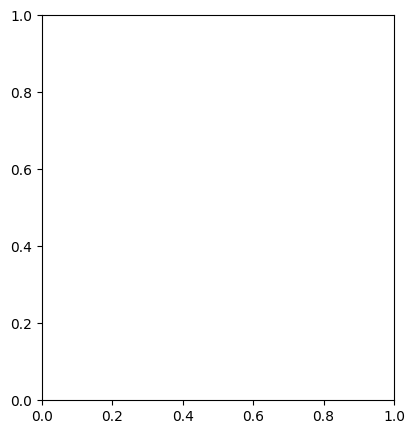

In [412]:
plt.figure(figsize=(10,5))


piv = oai_df.pivot_table(values=['tx_bytes', 'rx_bytes'], index='time', columns='rnti')
thr = piv.diff()/1000


ax1=plt.subplot(1,2,1)
for rnti in ['6807', 'b27d', 'e5aa']:
    ax1.plot(thr.index, thr.rx_bytes[rnti], '-', label=f"{rnti}")


ax2=plt.subplot(1,2,2)
for rnti in ['6807', 'b27d', 'e5aa']:
    ax2.plot(thr.index, thr.tx_bytes[rnti], '-', label=f"{rnti}")

ax1.set_xlim(t0, t0+duration)
ax2.set_xlim(t0, t0+duration)

ax1.set_ylabel("MAC Throughput DL [kb/s]")
ax2.set_ylabel("MAC Throughput UL [kb/s]")

ax1.set_xlabel("time [s]")
ax2.set_xlabel("time [s]")


plt.legend()

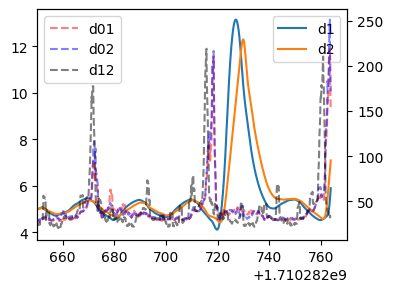

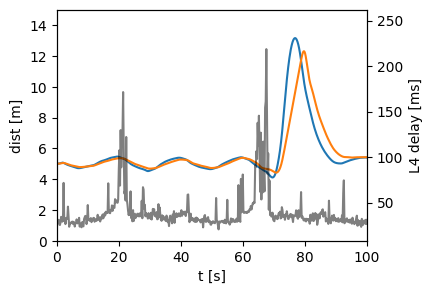

In [451]:
#Distance over time
dist1 = sumo_df[sumo_df.sumo_id=='p.1'].dist
dist2 = sumo_df[sumo_df.sumo_id=='p.2'].dist



plt.figure(figsize=(4,3))

ax = plt.subplot()

ax.plot(dist1.index-t0, dist1.values, label='d1')
ax.plot(dist1.index-t0, dist2.values, label='d2')
ax.set_xlim(0, duration)

ax2 = ax.twinx()
#delay1 = sumo_net_df[sumo_net_df.link == '0 1'].delay.rolling(10).mean()

sumo_net_df['ts'] = pd.to_datetime(sumo_net_df.index, unit='s')

sumo_net_df_idx = sumo_net_df.set_index('ts')
delay = sumo_net_df_idx.groupby(pd.Grouper(freq='200ms')).delay.mean()

ax2.plot(delay.index.values.astype(np.int64)/1e9-t0,  delay.values, alpha=0.5, color='k',label='d')
ax2.set_xlim(0, duration)
ax.set_ylim(0,15)

ax.set_xlabel("t [s]")
ax.set_ylabel("dist [m]")
ax2.set_ylabel("L4 delay [ms]")

plt.savefig("delay_dist.pdf")

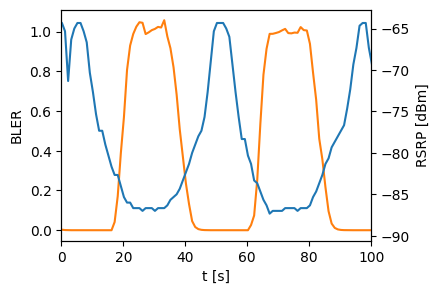

In [453]:

bler_avg = oai_df_idx.groupby('time').dl_bler.mean()

rsrp_avg = oai_df_idx.groupby('time').rsrp.mean()

plt.figure(figsize=(4,3))
ax = plt.subplot()

ax.plot(bler_avg.index-t0, bler_avg.values, 'C1', alpha=1, label='bler')
ax.set_xlim(0, duration)


ax2 = ax.twinx()


ax2.plot(rsrp_avg[rsrp_avg.notna()].index-t0, rsrp_avg[rsrp_avg.notna()].values, 'C0', alpha=1, label='RSRP')


ax2.set_xlim(0, duration)



ax.set_xlabel("t [s]")
ax.set_ylabel("BLER")
ax2.set_ylabel("RSRP [dBm]")

plt.savefig("bler_RSRP.pdf")